In [27]:
# Librerias utilizadas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

# Importación de datos

In [13]:
df = pd.read_csv('data/DATA_36.85_-4.24.csv')
df.head()

,DATA,spdi_1,spdi_3,spdi_6,spdi_9,spdi_12,spdi_24,spdi_36,spdi_48,spei_1,...,spi_6,spi_9,spi_12,spi_24,spi_36,spi_48,scpdsi,scphdi,sczindex,scwplm
0,1961-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.08,-0.08,-0.57,-0.08
1,1961-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.20,-0.20,-0.90,-0.20
2,1961-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,-0.25,-0.39,-0.25
3,1961-01-23,-0.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.47,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.35,-0.35,-0.80,-0.35
4,1961-02-01,-0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.79,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.47,-0.47,-0.88,-0.47


# Preprocesamiento de datos

In [14]:
spi_1 = df['spi_1']
# Quitamos valores vacios
spi_1 = spi_1.dropna(how='all')
# Comprobamos que solo eran vacios los iniciales
print(len(spi_1))
print(spi_1.index[-1]-spi_1.index[0]+1)
spi_1.head()

2925
2925


3   -0.50
4   -0.77
5   -0.87
6   -1.36
7   -1.73
Name: spi_1, dtype: float64

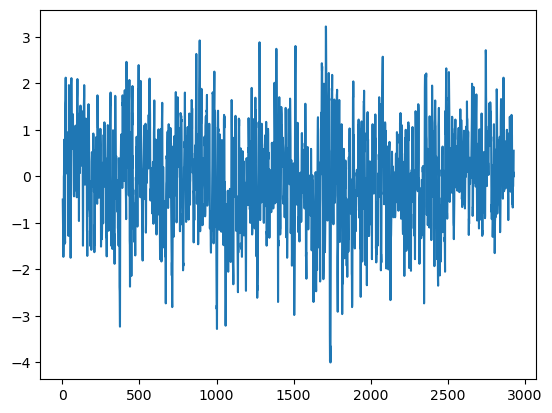

In [15]:
spi_1.plot()
plt.show()

In [16]:
# Separación en conjunto de entrenamiento y de prueba
train_df, test_df = train_test_split(spi_1, test_size=0.13, shuffle=False)

In [17]:
# Creamos un dataset sequencial con arrays de valores input/output
# Este dataset tiene la estructura adecuada para los datos de entrada
# en la red neuronal
def to_sequences(seq_size, obs):
    x = []
    y = []

    for i in range(len(obs)-seq_size):
        window = obs.iloc[i:(i+seq_size)]
        after_window = obs.iloc[i+seq_size]
        window = [[x] for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)
    
    
sequence_size = 10
X_train,y_train = to_sequences(sequence_size, train_df)
X_test,y_test = to_sequences(sequence_size, test_df)

print("Dimensiones del training set: {}".format(X_train.shape))
print("Dimensiones del test set: {}".format(X_test.shape))

Dimensiones del training set: (2534, 10, 1)
Dimensiones del test set: (371, 10, 1)


# Transformer encoder

In [18]:
# Extraido de https://keras.io/examples/timeseries/timeseries_transformer_classification/
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

# Construccion del modelo

In [19]:
# Funcion de construccion del modelo
# Extraida de https://keras.io/examples/timeseries/timeseries_transformer_classification/
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

# Definición del modelo

In [20]:
input_shape = X_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256, 
    num_heads=4, # Numero de capas de atencion paralelas
    ff_dim=4, 
    num_transformer_blocks=2, 
    mlp_units=[128], 
    mlp_dropout=0.4,
    dropout=0.25,
)

model.summary()

# Compilación del modelo

In [28]:
model.compile(optimizer='adam', loss='mse')

# Entrenamiento del modelo

In [29]:
# Creamos un early stopping para evitar overfitting
es = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

In [32]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=20,
     callbacks=[es],
     verbose=2, shuffle=False, validation_data=(X_test, y_test)
)


Epoch 1/100
127/127 - 5s - loss: 0.3455 - val_loss: 0.1978 - 5s/epoch - 42ms/step
Epoch 2/100
127/127 - 5s - loss: 0.3441 - val_loss: 0.1987 - 5s/epoch - 35ms/step
Epoch 3/100
127/127 - 6s - loss: 0.3355 - val_loss: 0.1978 - 6s/epoch - 46ms/step
Epoch 4/100
127/127 - 5s - loss: 0.3349 - val_loss: 0.1984 - 5s/epoch - 39ms/step
Epoch 5/100
127/127 - 5s - loss: 0.3400 - val_loss: 0.1954 - 5s/epoch - 37ms/step
Epoch 6/100
127/127 - 5s - loss: 0.3312 - val_loss: 0.1971 - 5s/epoch - 41ms/step
Epoch 7/100
127/127 - 5s - loss: 0.3351 - val_loss: 0.1973 - 5s/epoch - 39ms/step
Epoch 8/100
127/127 - 6s - loss: 0.3365 - val_loss: 0.1954 - 6s/epoch - 46ms/step
Epoch 8: early stopping


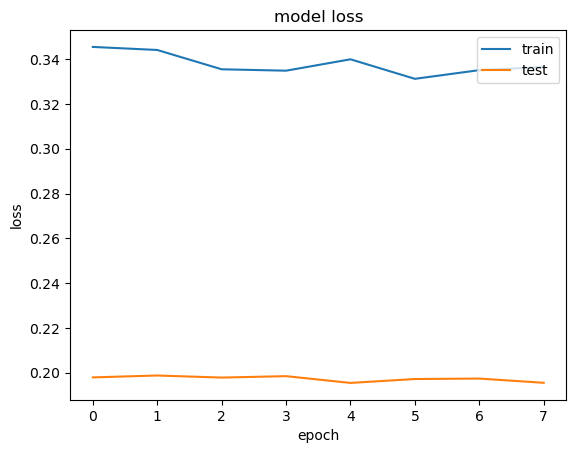

In [33]:
# Resumen del entrenamiento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Evaluación del modelo

In [34]:
train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)
train_score = model.evaluate(X_train, y_train)
test_score = model.evaluate(X_test, y_test)
print('Train score: {} MSE'.format(train_score))
print('Test score: {} MSE'.format(test_score))

12/12 [==============================] - 0s 9ms/step - loss: 0.1954
Train score: 0.30403295159339905 MSE
Test score: 0.1954248696565628 MSE


# Visualización de la predicción

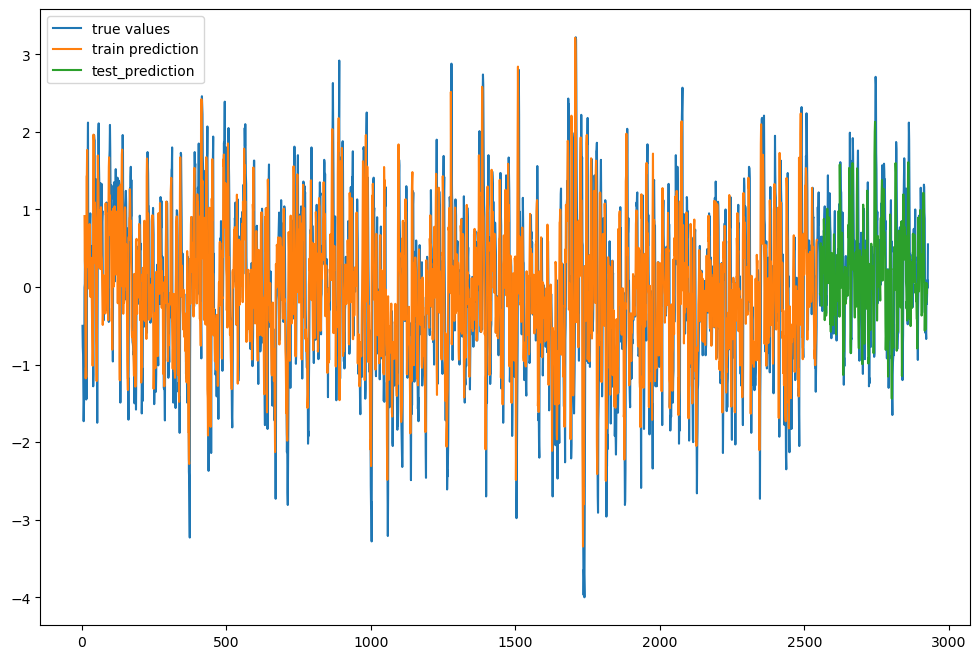

In [35]:
# Visualize the prediction
plt.figure(figsize=(12, 8))
train_stamp = np.arange(sequence_size, sequence_size + X_train.shape[0])
test_stamp = np.arange(2 * sequence_size + X_train.shape[0], len(spi_1))
plt.plot(spi_1, label='true values')
plt.plot(train_stamp, train_prediction, label='train prediction')
plt.plot(test_stamp, test_prediction, label = 'test_prediction')
plt.legend()
plt.show()